In [1]:
import sys

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import prep_for_model_runs as prep
import model_params_class as mp
import run_models as run
import sys
import generate_matrix as inputs
import plot_utils
sys.path.append('../')

saving group size matrix to GROUP_SIZE.csv


/Users/rachelwarren/projects/CPE-COVID-disparities/model/generate_matrix.py:158: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  contact_matrix_pre_sip[g] = 0.0
/Users/rachelwarren/projects/CPE-COVID-disparities/model/generate_matrix.py:263: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  white_at_home['hours_prop'] = white_at_home['Race_Home_Hours'] / white_at_home['Race_Home_Hours'].sum()
/Users/rachelwarren/projects/CPE-COVID-disparities/model/generate_matrix.py:265: SettingWithCopyWarning: 
A value is tryin

In [2]:
import sys
!conda install --yes --prefix {sys.prefix} matplotlib

Solving environment: done

# All requested packages already installed.



## Deterministic SIR model for multi-groups 
See: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4002176/


The model works like this: 
- Let's say we have N groups with size n_0 .... n_N
- Define four vectors (S = 'Susceptible, I = Infected, R = Recovered, D = Died) for each of the groups
    - for example: $\vec{I} = < I_0, I_1 \dots I_N >$ is the vector for the number of currently infected people in each subpopulation
- Assume a "contact matrix" $C = c_{ij} $ where $c_{ij}$ is the expected rate of contacts between groups i and j.
    - for example if $c_{i,j}$ = 0.1 that means that average number of contacts that an individual in group i has with group j is 0.1 --> i.e. there is a 1/10 chance they see anyone 
- Assume a "transmission matrix" $T = t_{ij}$ where $t_{ij}$  is the expected transmission between groups i and j if they make contact
    - The following code assumes that this is 1 (e.g. transmission rate is rolled into contact matrix) and is constant across groups. 
    - In a more sophisticated model, this assumption is not true. The transmission rate should not even be reciprocal. For example, if police are wearing masks when they interact with a community member, but there hands are equipment are dirty transmission rate could be higher in one direction. Transmission rate could also be higher for different types of interactions
- $\vec{\gamma}$ is the recovery rate .. e.g. $\gamma_i$ the likelihood that on a given day a sick person in group i recovers. We are using 1/14
- $\vec{\mu}$ is the death rate (divided by average disease duration) for each group

Combining contact and transmission, we can define a vector $\vec{\lambda}$ where $\lambda_i$ is the new infection rate (called the force of infection in the literature). 

- Force of infection = contact x transmission or $\lambda_i = \sum_j^N c_{ij} * t_{ij} $

Given $\vec{\lambda}$ the vector with contact rate * transmission rate, we can define our differential equations as follows:(Note that $t$ is current time and $t-1$ is previous time point. 

- Sub population totals : $\vec{N} = \vec{I_t} + \vec{R_t} + \vec{S_t} + \vec{D_t}$
- Susceptible number of people by sup-population: $\vec{S_t} = \vec{S_{t-1}} - \vec{I_{t-1}}$
- Infected by subpopulation $\vec{I_t} = \vec{I_{t-1}}+  \vec{\lambda} * \vec{S_{t-1}} * \frac{\vec{I_{t-1}}}{\vec{N}} - \vec{\gamma} \vec{I_{t-1}} - \vec{\mu} \vec{I_{t-1}}$ 
    - $\vec{I_t} =$ infected people before + newly infected people - infected people who recover
    - newly infected people = susceptible population * contact rate * transmission rate * proportion of population infected 
    - $\frac{\vec{I_{t-1}}}{\vec{N}}$ is the proportion of members of each group that are infected
- Recovered by Group: $\vec{R_t} = \vec{R_{t-1}} + \vec{\gamma} \vec{I_{t-1}}$

The implementation of this model does not try to count the number of individuals who have died, which simplifies it. 

In [3]:
def clean_df_names(df):
    df.columns = df.columns.str.strip()
    df.index = df.index.map(lambda s: s.strip())
    return df

In [33]:
"""Run multiple versions of the model, varying certain parameters to quantify uncertainty

params
------
base_dir: String
    the name of the directory where contact matrices and group size matrices are stored
    
starting_params: object of class ModelParams
    contains the initial parameters for the original model run
    
prison_peak_date: Int
    the day on which the prison infection rate peaks
    
days: Int
    the number of days to run the model for
    
returns
-------
monster_summary_stats: a DataFrame of all of the summary statistics for the model runs
infection_maps: a dictionary where the keys are stylized versions of a list of the starting parameters and the 
    values are infection_df's generated by these combinations of starting parameters
pd.concat(pop_sizes): a DataFrame that is a stacked version of all pop_size_df's output by the various model runs
"""
def run_models(policy_input_dirs, starting_param_dict, days):
    monster_summary_stats = pd.DataFrame({})
    infection_maps = {}
    s_maps = {}
    pop_sizes = []
    pc = 10 #police contacts
    pgrp = 17 #police group size. Eventually should parametrize of have the dif. uncertainty
    
    for policy_name, policy_input_path in policy_input_dirs.items():
        starting_params = starting_param_dict[policy_name]
        #params = starting_params.add_uncertainty_params(prison_infection_rate, pc, pgrp)
        contact_data_post_sip = pd.read_csv(
            os.path.join(policy_input_path, inputs.CONTACT_MATRIX_POST_SIP)).set_index('Group_Name')
       
        contact_data_pre_SIP = clean_df_names(pd.read_csv(
            os.path.join(policy_input_path, inputs.CONTACT_MATRIX_PRE_SIP)).set_index('Group_Name'))

        group_size_data = pd.read_csv(os.path.join(policy_input_path, inputs.GROUP_SIZE_MATRIX), index_col = 0)
        jail_release_date = starting_params.sip_start_date + 7
        jail_release_shrink = 0.4
        print(policy_name)
        summary, infection_df, s_df, pop_size_df = run.run_model_simple(
                policy_input_path, starting_params, days, group_size_data,contact_data_pre_SIP,
                        contact_data_post_sip)                                             

        infection_maps[policy_name] = infection_df
        s_maps[policy_name] = s_df
        pop_size_df['name'] = policy_name
        pop_sizes.append(pop_size_df)
        summary['Policy_Lever'] = policy_name        
        summary['Initial_Infections'] = starting_params.initial_infection_multiplier
        summary['Lockdown_Date'] = starting_params.sip_start_date
        summary['Prison_Rate'] = starting_params.prison_infection_rate
        summary['Police_Contact_Rate'] = 10
        summary['Police_Group_Size'] = 17 # Todo add to contact matrix code that we produce several of these. 
        #Then modify code accordingly
        monster_summary_stats= monster_summary_stats.append(summary)
        
    return monster_summary_stats, infection_maps, s_maps, pd.concat(pop_sizes)
    

saving group size matrix to GROUP_SIZE.csv


In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
#delete and recreate folders so we get a clean run each time. 
INPUT_BASE_DIR = '../input2'
import generate_matrix as inputs
for folder in ['model', 'figures', 'output']:
    if not os.path.exists(folder):
        os.mkdir(folder)
os.system(f"rm -rf {INPUT_BASE_DIR}")

original_dir, lever_1_dir, lever_2_dir = inputs.write_all_matrices(INPUT_BASE_DIR)

In [36]:
#inputs.compare_to_spread_sheet()

In [37]:
pd.options.mode.chained_assignment = None

In [84]:
# Initial Input Parameters
PRISON_PEAK_DATE = 30
TRANSMISSION_RATE = 0.015
POST_SIP_TRANMISSION_RATE = TRANSMISSION_RATE/2
SIP_START_DATE  = 14
INITIAL_INFECTION_RATE = 2

OUTPUT_DIR = 'output/'  #input2/CONTACT_MATRIX_POST_SIP.csv
CONTACT_MATRIX_PATH = 'CONTACT_MATRIX_POST_SIP.csv'
PRE_SOCIAL_DISTANCE_CONTACT_MATRIX = "CONTACT_MATRIX_PRE_SIP.csv"
GROUP_SIZE_PATH = 'GROUP_SIZE.csv'
DAYS = 200
prison_infection_rate = 0.35
starting_params = mp.ModelParams(TRANSMISSION_RATE, SIP_START_DATE, INITIAL_INFECTION_RATE,
                                 PRISON_PEAK_DATE, prison_infection_rate,
                                 post_sip_t=POST_SIP_TRANMISSION_RATE)

no_prison_params = mp.ModelParams(TRANSMISSION_RATE, SIP_START_DATE, INITIAL_INFECTION_RATE,
                                 PRISON_PEAK_DATE, 0.0001,
                                 post_sip_t=POST_SIP_TRANMISSION_RATE)

# summary_stats, infection_maps, s_maps, group_sizes = run_models(
#     {inputs.ORIGINAL_FOLDER: original_dir,'no_prison': original_dir},
#     {inputs.ORIGINAL_FOLDER: starting_params, 'no_prison': no_prison_params}, DAYS)

summary_stats, infection_maps, s_maps, group_sizes = run_models(
    {inputs.ORIGINAL_FOLDER: original_dir, 'no_prison': original_dir},
    {inputs.ORIGINAL_FOLDER: starting_params, 'no_prison': no_prison_params}, DAYS)

summary_stats.to_csv(os.path.join(OUTPUT_DIR, f'full_summary_stats_{TRANSMISSION_RATE}.csv'))
group_sizes = group_sizes.set_index('name')

no_policy
Prison infection rate 0.35
no_prison
Prison infection rate 0.0001


In [85]:
# Plot the Code

In [86]:
summary_stats[['cumulative_rate_40_days', 'cumulative_rate_120_days']]

,cumulative_rate_40_days,cumulative_rate_120_days
Group_Name,,
Black,0.027380,0.43
Black_Forced_Labour,0.024150,0.51
White,0.013061,0.43
White_Forced_Labour,0.014950,0.50
Total_Residents,0.015703,0.44
Total_w_Police,0.015724,0.44
Black_All,0.026762,0.45
White_All,0.013348,0.44
Black,0.001118,0.04


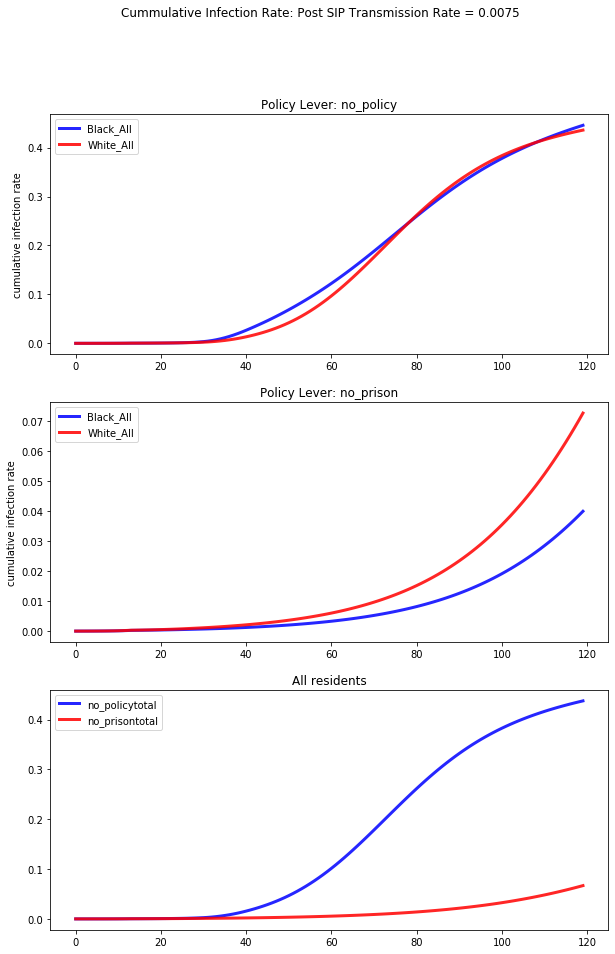

In [87]:
plot_utils.make_susceptable_plot(
    s_maps, group_sizes,
    f'Cummulative Infection Rate: Post SIP Transmission Rate = {POST_SIP_TRANMISSION_RATE}', policies=['no_policy', 'no_prison'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118100510>,
      dtype=object)

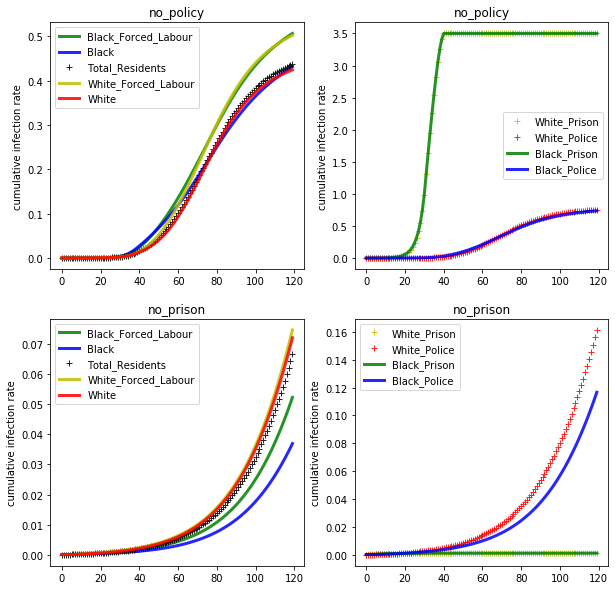

In [88]:
plot_utils.plot_all_groups(s_maps, group_sizes, policies=['no_policy', 'no_prison'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a986dd0>,
      dtype=object)

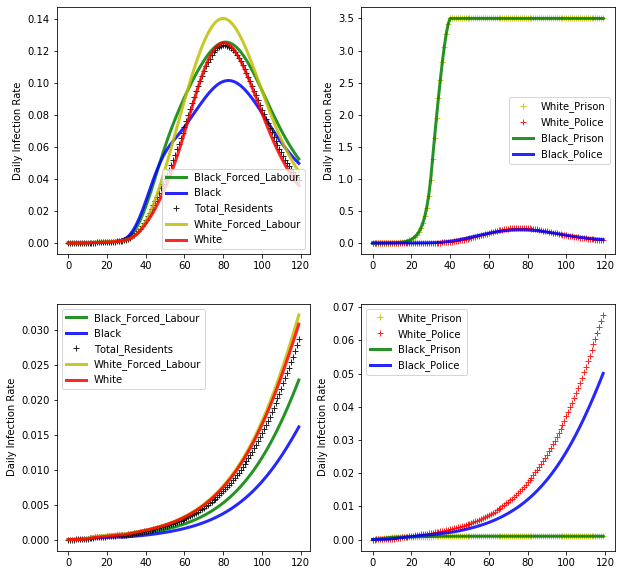

In [89]:
plot_utils.plot_all_groups_infection(infection_maps, group_sizes, policies=['no_policy', 'no_prison'])  

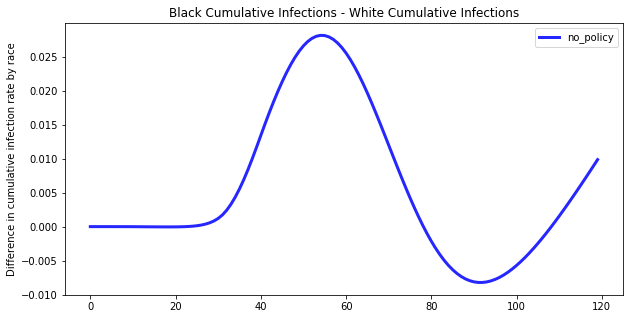

In [90]:
plot_utils.make_susceptable_plot_racial_dif(s_maps, group_sizes, f'Black Cumulative Infections - White Cumulative Infections')

In [91]:

TRANSMISSION_RATE = 0.02

POST_SIP_TRANMISSION_RATE = TRANSMISSION_RATE/2



starting_params = mp.ModelParams(TRANSMISSION_RATE, SIP_START_DATE, INITIAL_INFECTION_RATE,
                                 PRISON_PEAK_DATE, prison_infection_rate,
                                 post_sip_t=POST_SIP_TRANMISSION_RATE)

no_prison_params = mp.ModelParams(TRANSMISSION_RATE, SIP_START_DATE, INITIAL_INFECTION_RATE,
                                 PRISON_PEAK_DATE, 0.0001,
                                 post_sip_t=POST_SIP_TRANMISSION_RATE)


summary_stats, infection_maps, s_maps, group_sizes = run_models(
    {inputs.ORIGINAL_FOLDER: original_dir, 'no_prison': original_dir},
    {inputs.ORIGINAL_FOLDER: starting_params, 'no_prison': no_prison_params}, DAYS)

summary_stats.to_csv(os.path.join(OUTPUT_DIR, f'full_summary_stats_{TRANSMISSION_RATE}.csv'))
group_sizes = group_sizes.set_index('name')


summary_stats[['cumulative_rate_40_days', 'cumulative_rate_120_days']]


no_policy
Prison infection rate 0.35
no_prison
Prison infection rate 0.0001


,cumulative_rate_40_days,cumulative_rate_120_days
Group_Name,,
Black,0.042857,0.60
Black_Forced_Labour,0.043253,0.71
White,0.030302,0.59
White_Forced_Labour,0.035251,0.70
Total_Residents,0.033139,0.61
Total_w_Police,0.033211,0.61
Black_All,0.042933,0.62
White_All,0.031053,0.61
Black,0.006435,0.36


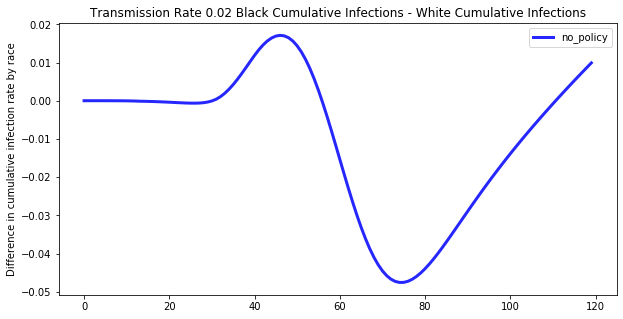

In [92]:
plot_utils.make_susceptable_plot_racial_dif(s_maps, group_sizes, f'Transmission Rate {TRANSMISSION_RATE} Black Cumulative Infections - White Cumulative Infections')

Text(0.5, 0, ' Transmission Rate = 0.02')

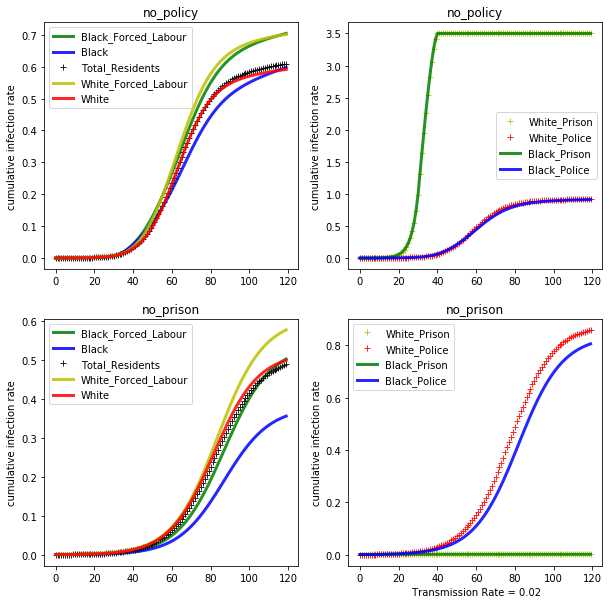

In [97]:
ax = plot_utils.plot_all_groups(s_maps, group_sizes, policies=['no_policy', 'no_prison'] )
ax[1,1].set_xlabel(f' Transmission Rate = {TRANSMISSION_RATE}')